In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np

# Study dataset

In [2]:
interactions_path = "zvuk-dataset/zvuk-interactions.parquet"
embeddings_path = "zvuk-dataset/zvuk-track_artist_embedding.parquet"

interactions = pl.read_parquet(interactions_path)
embeddings = pl.read_parquet(embeddings_path)

print("Interactions Dataset:")
print(interactions.head())

print("Embeddings Dataset:")
print(embeddings.head())

Interactions Dataset:
shape: (5, 5)
┌─────────┬────────────┬─────────────────────────┬──────────┬───────────────┐
│ user_id ┆ session_id ┆ datetime                ┆ track_id ┆ play_duration │
│ ---     ┆ ---        ┆ ---                     ┆ ---      ┆ ---           │
│ i32     ┆ i32        ┆ datetime[ms]            ┆ i32      ┆ f32           │
╞═════════╪════════════╪═════════════════════════╪══════════╪═══════════════╡
│ 1938823 ┆ 2200336    ┆ 2023-03-18 11:43:57.856 ┆ 1242546  ┆ 23.999992     │
│ 1938823 ┆ 2200336    ┆ 2023-03-18 11:43:58.114 ┆ 145031   ┆ 2.0           │
│ 1938823 ┆ 2200336    ┆ 2023-03-18 11:45:12.932 ┆ 145031   ┆ 34.0          │
│ 1938823 ┆ 2200336    ┆ 2023-03-18 11:45:27.808 ┆ 1501837  ┆ 18.0          │
│ 1938823 ┆ 2200336    ┆ 2023-03-18 11:45:42.891 ┆ 1402020  ┆ 2.0           │
└─────────┴────────────┴─────────────────────────┴──────────┴───────────────┘
Embeddings Dataset:
shape: (5, 4)
┌──────────┬───────────┬────────────┬─────────────────────────────────┐


In [3]:
print("Interactions Dataset Info:")
print(interactions.describe())
print("Missing Values in Interactions:")
print(interactions.null_count())

Interactions Dataset Info:
shape: (9, 6)
┌────────────┬──────────────┬──────────────┬─────────────────┬───────────────┬───────────────┐
│ statistic  ┆ user_id      ┆ session_id   ┆ datetime        ┆ track_id      ┆ play_duration │
│ ---        ┆ ---          ┆ ---          ┆ ---             ┆ ---           ┆ ---           │
│ str        ┆ f64          ┆ f64          ┆ str             ┆ f64           ┆ f64           │
╞════════════╪══════════════╪══════════════╪═════════════════╪═══════════════╪═══════════════╡
│ count      ┆ 2.44673551e8 ┆ 2.44673551e8 ┆ 244673551       ┆ 2.44673551e8  ┆ 2.44673551e8  │
│ null_count ┆ 0.0          ┆ 0.0          ┆ 0               ┆ 0.0           ┆ 0.0           │
│ mean       ┆ 5.4997e6     ┆ 6.7851e6     ┆ 2023-03-18      ┆ 752716.818351 ┆ 101.954681    │
│            ┆              ┆              ┆ 19:10:19.420000 ┆               ┆               │
│ std        ┆ 2.5976e6     ┆ 3.8483e6     ┆ null            ┆ 435755.710418 ┆ 662.45697     │
│ min    

In [4]:
print("Embeddings Dataset Info:")
print(embeddings.describe())
print("Missing Values in Embeddings:")
print(embeddings.null_count())

Embeddings Dataset Info:
shape: (9, 5)
┌────────────┬───────────────┬───────────────┬────────────┬────────────┐
│ statistic  ┆ track_id      ┆ artist_id     ┆ cluster_id ┆ vector     │
│ ---        ┆ ---           ┆ ---           ┆ ---        ┆ ---        │
│ str        ┆ f64           ┆ f64           ┆ f64        ┆ f64        │
╞════════════╪═══════════════╪═══════════════╪════════════╪════════════╡
│ count      ┆ 2.199876e6    ┆ 2.199876e6    ┆ 2.199876e6 ┆ 2.199876e6 │
│ null_count ┆ 0.0           ┆ 0.0           ┆ 0.0        ┆ 0.0        │
│ mean       ┆ 753231.702561 ┆ 130056.924591 ┆ 63.940677  ┆ null       │
│ std        ┆ 435076.325834 ┆ 75428.318523  ┆ 36.733364  ┆ null       │
│ min        ┆ 0.0           ┆ 0.0           ┆ 0.0        ┆ null       │
│ 25%        ┆ 376312.0      ┆ 64973.0       ┆ 33.0       ┆ null       │
│ 50%        ┆ 753023.0      ┆ 129585.0      ┆ 61.0       ┆ null       │
│ 75%        ┆ 1.12992e6     ┆ 195326.0      ┆ 95.0       ┆ null       │
│ max       

In [5]:
unique_users = interactions["user_id"].n_unique()
unique_sessions = interactions["session_id"].n_unique()
unique_tracks = interactions["track_id"].n_unique()

print(f"Unique Users: {unique_users}")
print(f"Unique Sessions: {unique_sessions}")
print(f"Unique Tracks: {unique_tracks}")

Unique Users: 382790
Unique Sessions: 12598314
Unique Tracks: 1506950


# Top tracks

In [6]:
song_popularity_count = interactions.group_by("track_id").agg(
    pl.count("play_duration").alias("song_popularity")
)
song_popularity_duration = interactions.group_by("track_id").agg(
    pl.mean("play_duration").alias("song_mean_play_duration")
)

In [12]:
song_popularity_count.sort(by="song_popularity", descending=True).head(10)

track_id,song_popularity
i32,u32
634651,564162
811300,445756
1133665,398559
44204,376416
137427,362490
278845,356906
1355970,351931
265134,345022
412548,330006


In [17]:
interactions.group_by("track_id").agg(
    pl.struct("user_id").n_unique().alias("result")
).sort(by="result", descending=True).head(10)

track_id,result
i32,u32
634651,89860
811300,80468
44204,73603
265134,68336
1355970,65879
412548,61644
647096,61580
1133665,61155
322362,60719


In [13]:
song_popularity_duration.sort(by="song_mean_play_duration", descending=True).head(10)

track_id,song_mean_play_duration
i32,f32
107684,857.0
28334,815.789917
1328052,745.719421
484250,719.0
154426,719.0
504266,719.0
1403878,719.0
176924,719.0
1123839,719.0


In [19]:
user_interaction_counts = interactions.group_by("user_id").agg(
    pl.count("track_id").alias("interaction_count")
)
low_interaction_users = user_interaction_counts.filter(pl.col("interaction_count") < 5)

print(f"Users with fewer than 5 interactions: {low_interaction_users.shape[0]}")
print(low_interaction_users)

Users with fewer than 5 interactions: 20042
shape: (20_042, 2)
┌─────────┬───────────────────┐
│ user_id ┆ interaction_count │
│ ---     ┆ ---               │
│ i32     ┆ u32               │
╞═════════╪═══════════════════╡
│ 1465358 ┆ 2                 │
│ 1617486 ┆ 3                 │
│ 8554834 ┆ 4                 │
│ 6852806 ┆ 4                 │
│ 3128265 ┆ 1                 │
│ …       ┆ …                 │
│ 9148963 ┆ 4                 │
│ 8733670 ┆ 1                 │
│ 6466422 ┆ 2                 │
│ 6233503 ┆ 3                 │
│ 1838248 ┆ 2                 │
└─────────┴───────────────────┘


# Session & embedding analyse

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


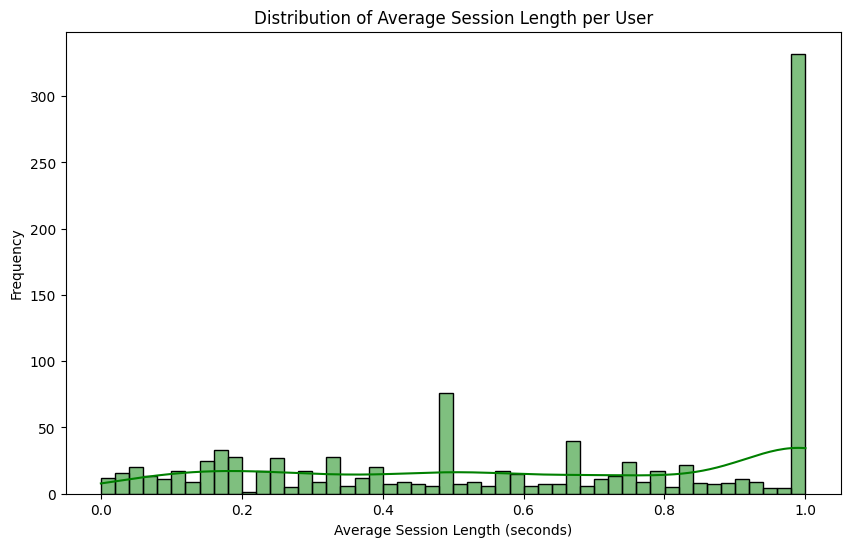

In [21]:
user_avg_session_length = interactions.group_by("user_id").agg(
    pl.mean("play_duration").alias("avg_session_length")
).filter((0 < pl.col("avg_session_length")) & (pl.col("avg_session_length") < 1))

plt.figure(figsize=(10, 6))
sns.histplot(user_avg_session_length["avg_session_length"].to_numpy(), kde=True, bins=50, color="green")
plt.title("Distribution of Average Session Length per User")
plt.xlabel("Average Session Length (seconds)")
plt.ylabel("Frequency")
plt.show()

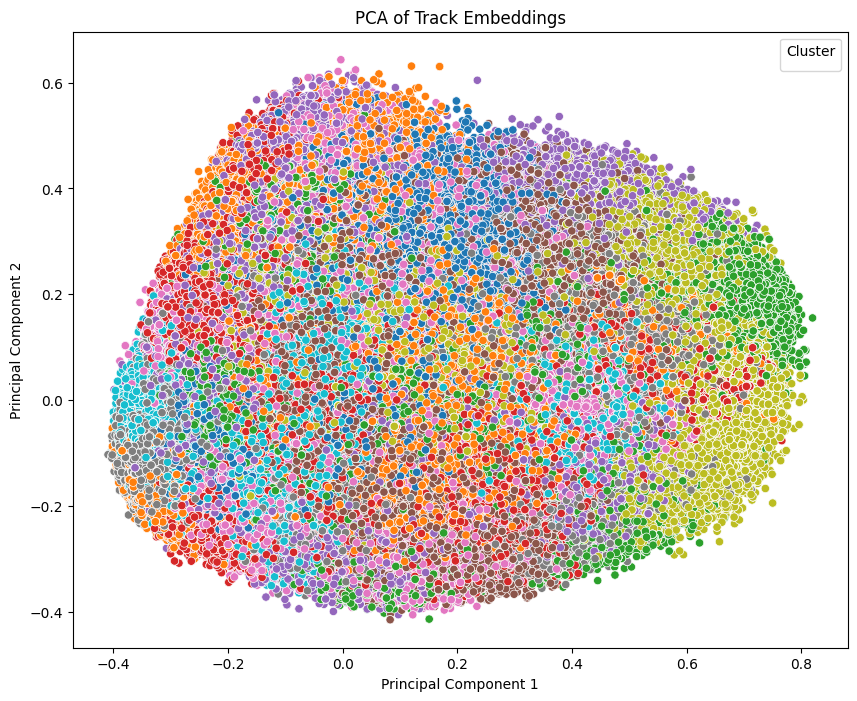

In [23]:
vectors = np.vstack(embeddings["vector"].to_numpy())
cluster_ids = embeddings["cluster_id"].to_numpy()

pca = PCA(n_components=2)
vectors_pca = pca.fit_transform(vectors)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=vectors_pca[:, 0], y=vectors_pca[:, 1], hue=cluster_ids, palette="tab10", legend=False)
plt.title("PCA of Track Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()